# Data for Deep Ensembles as BMA

In [11]:
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.utils.data
from torch import nn
from torch.nn import functional as F

import seaborn as sns

from swag import data, models, utils, losses
from swag.posteriors import SWAG


from tqdm import tqdm

import os

torch.backends.cudnn.benchmark = True
torch.manual_seed(1)
torch.cuda.manual_seed(1)
np.random.seed(1)

import hamiltorch

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
class RegNet(nn.Sequential):
    def __init__(self, dimensions, input_dim=1, output_dim=1, apply_var=True):
        super(RegNet, self).__init__()
        self.dimensions = [input_dim, *dimensions, output_dim]        
        for i in range(len(self.dimensions) - 1):
            self.add_module('linear%d' % i, torch.nn.Linear(self.dimensions[i], self.dimensions[i + 1]))
            if i < len(self.dimensions) - 2:
                self.add_module('relu%d' % i, torch.nn.ReLU())

        if output_dim == 2:
            self.add_module('var_split', SplitDim(correction=apply_var))

    def forward(self, x, output_features=False):
        return super().forward(x)

In [3]:
net = RegNet(dimensions=[10, 10, 10], input_dim=2)

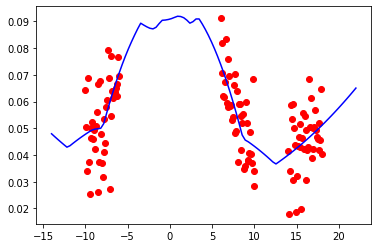

In [9]:
for p in net.parameters():
    p.data.normal_(std=0.1)

def featurize(x):
    return torch.cat([x[:, None], x[:, None]**2], dim=1)
    
x = torch.cat([torch.linspace(-10, -6, 40), torch.linspace(6, 10, 40), torch.linspace(14, 18, 40)])
# x = torch.cat([torch.linspace(-10, -6, 20), torch.linspace(6, 10, 20)])
f = featurize(x)
x_ = torch.linspace(-14, 22, 100)
f_ = featurize(x_)

y = net(f)
y_ = net(f_)

y += torch.randn_like(y) * .01
plt.plot(x.data.numpy(), y.data.numpy(), "ro")
plt.plot(x_.data.numpy(), y_.data.numpy(), "-b")

## Saving

In [289]:
# np.savez("data", x=x.data.numpy(), y=y.data.numpy(), x_=x_.data.numpy(), y_=y_.data.numpy())